In [1]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

In [2]:
%matplotlib inline

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE.upper()} device")

Using CUDA device


# Билет 13

## Задача 3

### Предобработка данных и подготовка датасета

In [5]:
credit_df = pd.read_csv("../data/classification/credit.csv")
print(credit_df.shape)
credit_df.head()

(24000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


Константных и уникальных признаков нет:

In [6]:
uniq_stat = credit_df.nunique()
uniq_stat[(uniq_stat == 1) | (uniq_stat == len(credit_df))]

Series([], dtype: int64)

Пропусков нет:

In [7]:
na_stat = credit_df.isna().sum()
na_stat[na_stat > 0]

Series([], dtype: int64)

Дубликаты присутствуют, удалим их:

In [8]:
credit_df[credit_df.duplicated()].value_counts()

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
20000      1    2          2         24    2      2      4      4      4      4     1650.0     1650.0     1650.0     1650.0     1650.0     1650.0     0.0       0.0       0.0       0.0       0.0       0.0       1          1
50000      1    2          2         26    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
360000     2    1          2         29    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
                           1         41   -2     -2     -2     -2     -2     -2     0.0        0.0        0.0    

In [9]:
credit_df = credit_df.drop_duplicates()
credit_df[credit_df.duplicated()].value_counts()

Series([], dtype: int64)

In [10]:
print(credit_df.shape)
credit_df.head()

(23976, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


Выборка несбалансированная. Для улучшения результата нужно будет взвесить ошибку по имеющимся данным

0    18675
1     5301
Name: default, dtype: int64


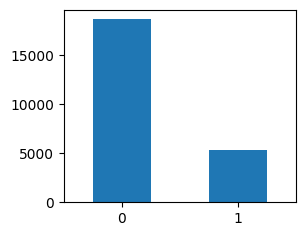

In [11]:
vc = credit_df["default"].value_counts()
print(vc)
credit_df["default"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

Реализует объекты Dataset для работы с DataLoader:

In [12]:
class CreditDataset(Dataset):

    def __init__(self, df, scaler=None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "default"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        self.data = torch.tensor(scale(data), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

Разделим выборку на тренировочную и тестовую, создадим объект Dataset для каждой, StandardScaler будем обучать только на тренировочных данных:

In [13]:
train_df, test_df = train_test_split(credit_df, test_size=0.2)

train_dataset = CreditDataset(train_df)
test_dataset = CreditDataset(test_df, scaler=train_dataset.scaler)
len(train_dataset), len(test_dataset), train_dataset.num_features, train_dataset.classes

(19180, 4796, 23, ['0', '1'])

Рассчитаем веса классов:

In [14]:
_, counts = train_dataset.targets.unique(return_counts=True)
weights = counts.max() / counts
weights

tensor([1.0000, 3.5483])

### Построение и обучение модели

Простой линейный классификатор в связке с функцией потерь `CrossEntropyLoss`, которая содержит фун-ию активации `logsoftmax`:

In [15]:
class CreditCNNClassifier(nn.Module):

    def __init__(self, num_features, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        return self.classifier(x)

In [16]:
net = CreditCNNClassifier(train_dataset.num_features, num_classes=len(train_dataset.classes)).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.002)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024)

net

CreditCNNClassifier(
  (classifier): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
)

Цикл обучения модели:

In [17]:
@torch.no_grad()
def get_y_true_y_pred(model, dataloader):
    model.eval()
    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)
    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)

In [18]:
train_loss_history = []
epochs = 15
for epoch in range(epochs):
    net.train()
    num_batches = len(train_dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    train_loss, train_accuracy = (avg_loss / num_batches).item(), avg_accuracy / num_batches
    train_loss_history.append(train_loss)

    net.eval()
    y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
    test_loss, test_accuracy = loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(),
                                                                                      y_pred.argmax(1).cpu())
    print(f"[Epoch {epoch + 1:>2}/{epochs}] Train: loss={train_loss:.6f}, accuracy={train_accuracy:.4f} | "
          f"Test: loss={test_loss:.6f}, accuracy={test_accuracy:.4f}")

[Epoch  1/15] Train: loss=0.613681, accuracy=0.6988 | Test: loss=0.591130, accuracy=0.7746
[Epoch  2/15] Train: loss=0.595410, accuracy=0.7438 | Test: loss=0.583305, accuracy=0.7790
[Epoch  3/15] Train: loss=0.583136, accuracy=0.7556 | Test: loss=0.580700, accuracy=0.7515
[Epoch  4/15] Train: loss=0.582983, accuracy=0.7512 | Test: loss=0.575030, accuracy=0.7736
[Epoch  5/15] Train: loss=0.579170, accuracy=0.7509 | Test: loss=0.575425, accuracy=0.7661
[Epoch  6/15] Train: loss=0.573432, accuracy=0.7552 | Test: loss=0.573169, accuracy=0.7683
[Epoch  7/15] Train: loss=0.576615, accuracy=0.7547 | Test: loss=0.573280, accuracy=0.7611
[Epoch  8/15] Train: loss=0.568789, accuracy=0.7581 | Test: loss=0.577882, accuracy=0.7596
[Epoch  9/15] Train: loss=0.570060, accuracy=0.7570 | Test: loss=0.571860, accuracy=0.7759
[Epoch 10/15] Train: loss=0.569624, accuracy=0.7544 | Test: loss=0.573398, accuracy=0.7679
[Epoch 11/15] Train: loss=0.568045, accuracy=0.7590 | Test: loss=0.571830, accuracy=0.7590

### Оценка и выводы

График значений функции потерь на обучающем множестве:

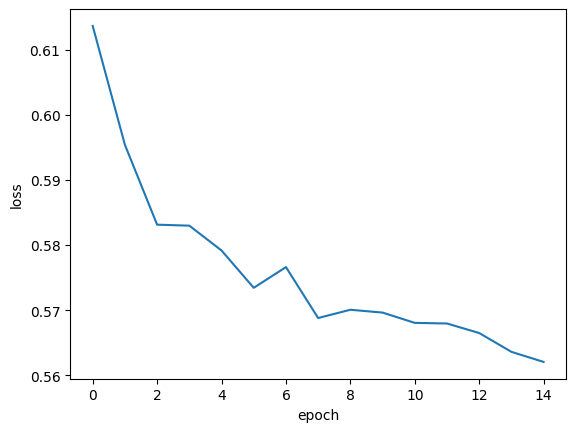

In [19]:
_, ax = plt.subplots(1, 1)

ax.plot(torch.arange(len(train_loss_history)), train_loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss");

In [20]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

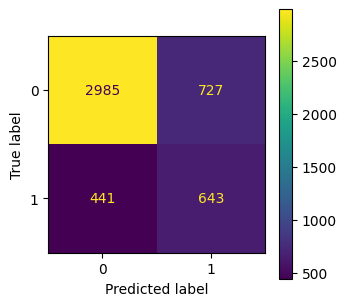

In [21]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    xticks_rotation=0,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [22]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      3712
           1       0.47      0.59      0.52      1084

    accuracy                           0.76      4796
   macro avg       0.67      0.70      0.68      4796
weighted avg       0.78      0.76      0.77      4796



Из-за сильной несбалансированности классов модель плохо справляется с распознаванием не доминирующего класса.

## Задача 2

### Предобработка данных и подготовка датасета

In [23]:
class WordVocab:
    PAD = "<PAD>"
    UNKNOWN = "<UNK>"

    def __init__(self, texts):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.i2w = [self.PAD, self.UNKNOWN, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.i2w)}
        unknown_idx = w2i[self.UNKNOWN]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.i2w)

    def encode(self, text):
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.PAD]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

In [24]:
RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
RE_ALPHA = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))
snowball_stemmer = nltk.SnowballStemmer(language="english")


class ActivitiesDataset(Dataset):

    def __init__(self, df, vocab=None, encoder=None):
        self.raw_texts = df["Text"].tolist()
        self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df["Review-Activity"])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    @staticmethod
    def preprocess_text(text):
        text = text.lower()
        for pat in [RE_URL, RE_ALPHA]:
            text = pat.sub(" ", text)

        words = []
        for word in nltk.word_tokenize(text):
            if word not in STOPWORDS and len(word) >= 3:
                word = snowball_stemmer.stem(word)
                if word not in STOPWORDS and len(word) >= 3:
                    words.append(word)

        return " ".join(words)

Выборка относительно сбалансированная:

ACTIVITY    5726
REVIEW      4274
Name: Review-Activity, dtype: int64


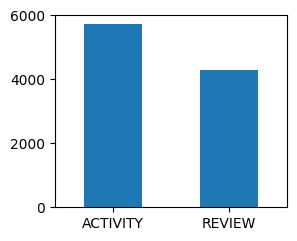

In [25]:
activities_df = pd.read_csv("../data/nlp/activities.csv")
vc = activities_df["Review-Activity"].value_counts()
print(vc)
activities_df["Review-Activity"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

По аналогии с предыдущим заданием Vocab и Encoder буду обучать только на тренировочной выборке:

In [26]:
train_df, test_df = train_test_split(activities_df, test_size=0.2, random_state=0)

train_dataset = ActivitiesDataset(train_df)
test_dataset = ActivitiesDataset(test_df, vocab=train_dataset.vocab, encoder=train_dataset.encoder)
print(len(train_dataset.vocab), train_dataset.vocab.max_len)
len(train_dataset), len(test_dataset), train_dataset.classes

13381 87


(8000, 2000, ['ACTIVITY', 'REVIEW'])

### Построение и обучение модели

Можно было RNN, можно было MLP (наверное, нельзя - делала в предыдущем задании) - сделаю CNN:

In [27]:
class ActivitiesCNNClassifier(nn.Module):

    def __init__(self, num_embeddings, embedding_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=0)
        self.features = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=32, kernel_size=2),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=2),
            nn.BatchNorm1d(num_features=64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        # сжатие размерности, предшествующей кол-ву слоев (как бы кол-во слов) до 8
        self.avgpool = nn.AdaptiveAvgPool1d(8)
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.embedding(x)
        x = torch.permute(x, dims=(0, 2, 1))
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [28]:
net = ActivitiesCNNClassifier(
    num_embeddings=len(train_dataset.vocab),
    embedding_dim=64,
    num_classes=len(train_dataset.classes),
).to(DEVICE)

# расчет весов классов
_, counts = train_dataset.targets.unique(return_counts=True)
weights = counts.max() / counts
loss_fn = nn.CrossEntropyLoss(weight=weights.to(DEVICE))
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=512, drop_last=True)

net

ActivitiesCNNClassifier(
  (embedding): Embedding(13381, 64, padding_idx=0)
  (features): Sequential(
    (0): Conv1d(64, 32, kernel_size=(2,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=8)
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [29]:
train_loss_history = []
epochs = 10
for epoch in range(epochs):
    net.train()
    num_batches = len(train_dataloader)
    avg_loss, avg_accuracy = 0, 0
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        pred = net(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)
        avg_loss += loss
        avg_accuracy += accuracy
    train_loss, train_accuracy = (avg_loss / num_batches).item(), avg_accuracy / num_batches
    train_loss_history.append(train_loss)

    net.eval()
    y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
    test_loss, test_accuracy = loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())
    print(f"[Epoch {epoch + 1:>2}/{epochs}] Train: loss={train_loss:.6f}, accuracy={train_accuracy:.4f} | "
          f"Test: loss={test_loss:.6f}, accuracy={test_accuracy:.4f}")

[Epoch  1/10] Train: loss=0.130389, accuracy=0.9567 | Test: loss=0.059323, accuracy=0.9785
[Epoch  2/10] Train: loss=0.045822, accuracy=0.9851 | Test: loss=0.032364, accuracy=0.9883
[Epoch  3/10] Train: loss=0.019546, accuracy=0.9937 | Test: loss=0.022532, accuracy=0.9928
[Epoch  4/10] Train: loss=0.008154, accuracy=0.9974 | Test: loss=0.031263, accuracy=0.9909
[Epoch  5/10] Train: loss=0.003003, accuracy=0.9991 | Test: loss=0.014888, accuracy=0.9935
[Epoch  6/10] Train: loss=0.001630, accuracy=0.9999 | Test: loss=0.014631, accuracy=0.9954
[Epoch  7/10] Train: loss=0.001519, accuracy=0.9996 | Test: loss=0.020901, accuracy=0.9941
[Epoch  8/10] Train: loss=0.000986, accuracy=0.9999 | Test: loss=0.017712, accuracy=0.9954
[Epoch  9/10] Train: loss=0.000323, accuracy=1.0000 | Test: loss=0.017871, accuracy=0.9941
[Epoch 10/10] Train: loss=0.000307, accuracy=1.0000 | Test: loss=0.016251, accuracy=0.9941


### Оценка и выводы

График значений функции потерь на обучающем множестве:

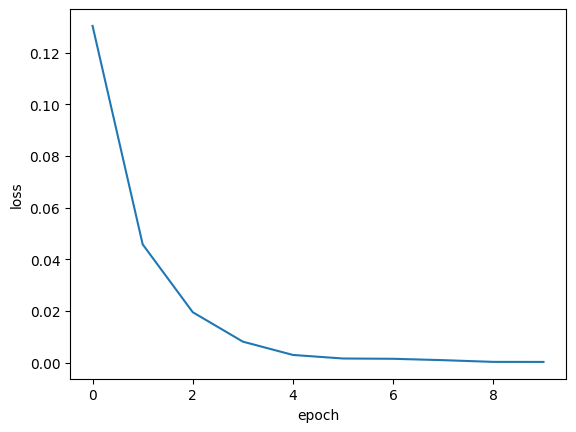

In [30]:
_, ax = plt.subplots(1, 1)

ax.plot(torch.arange(len(train_loss_history)), train_loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss");

In [31]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

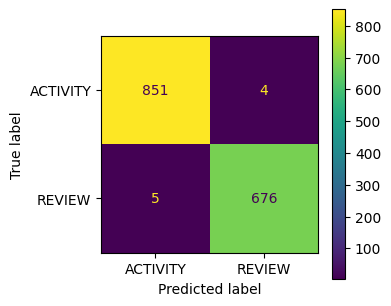

In [32]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=test_dataset.classes,
    xticks_rotation=0,
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [33]:
print(metrics.classification_report(y_true, y_pred, target_names=test_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

    ACTIVITY       0.99      1.00      0.99       855
      REVIEW       0.99      0.99      0.99       681

    accuracy                           0.99      1536
   macro avg       0.99      0.99      0.99      1536
weighted avg       0.99      0.99      0.99      1536



CNN модель отлично справилась с поставленной задачей.